In [1]:
import cvxpy as cp
import json

In [23]:
# pip install cvxpy

# 저자

- TA: 성준모 (Joonmo Sung)
- SYSTEMS MODELING AND PROGRAMMING LAB DEPARTMENT OF INDUSTRIAL ENGINEERING, YONSEI UNIVERSITY - SYMPLY
- 문의: `sjm21314@naver.com`,`sjm21314@yonsei.ac.kr`
***
본 강의자료는 Keha,A. B.,Khowala,K.,&Fowler,J. W. (2009). Mixed integer programming formulations for single machine scheduling problems. Computers & Industrial Engineering, 56(1), 357-367 논문을 바탕으로 제작되었으며,

반도체데이터사이언스 협동과정 수업 용도 이외의 목적으로 저자의 허락 없이 다른 사람들과 공유할 수 없습니다.

## Dataset
### Set
- J = $\{1,2,...,n\}, j \in J$ (Job)
- $\mu$ = $\{1,2, ..., m\}, i \in \mu$ (Machine)
### Parameters
- $p_j$: processing time of job $j$
- $d_j$: due date of job $j$
- $w_j$: weight of job $j$
- $r_j$: release date of job $j$

In [2]:
with open('data.json') as file:
    data = json.load(file)

In [3]:
print(len(data['N']))
print(data['p'])
print(data['d'])
print(data['w'])
print(data['r'])

5
{'0': 1, '1': 15, '2': 12, '3': 13, '4': 9}
{'0': 30, '1': 5, '2': 15, '3': 22, '4': 40}
{'0': 6, '1': 3, '2': 2, '3': 5, '4': 2}
{'0': 22, '1': 16, '2': 15, '3': 4, '4': 10}


In [4]:
# Offline 상황을 가정.

n = len(data['N']) # 작업의 개수
m = 2 # 기계의 개수 

# Sets
J = [_ for _ in range(n)] # 작업 set을 리스트 자료구조를 이용해 0, 1, 2,..., n-1 까지 담아줌
Mu = [_ for _ in range(m)] # 기계 set을 리스트 자료구조를 이용해 0, 1, 2,..., m-1 까지 담아줌

# Parameters
p = [data['p'][f'{i}'] for i in J] # 작업의 가공시간 데이터를 리스트 자료구조를 이용해 만들어 줌
d = [data['d'][f'{i}'] for i in J] # 작업의 마감 기한 데이터를 리스트 자료구조를 이용해 만들어 줌
w = [data['w'][f'{i}'] for i in J] # 작업의 가중치 데이터를 리스트 자료구조를 이용해 만들어 줌
r = [data['r'][f'{i}'] for i in J] # 작업의 release date(도착 시점) 데이터를 리스트 자료구조를 이용해 만들어 줌

M = (sum(p) + sum(r)) * 2 # big M

In [5]:
print(p)
print(d)
print(w)
print(r)

[1, 15, 12, 13, 9]
[30, 5, 15, 22, 40]
[6, 3, 2, 5, 2]
[22, 16, 15, 4, 10]


In [6]:
obj_select = 'wct' # 'wct', 'tj', 'twt', 'L_max' 'C_max' 중 하나 선택
release_time = True

# Identical Parallel machines (Pm) 상황을 가정

## M1 - Time-indexed model formulation

### Sets
- $\tau$: Set of time periods, t = 1,2,...,l

In [7]:
l = sum(p) + max(r) # l은 마지막 작업의 종료 시점에 대한 upper bound
Tau = [_ for _ in range(l)] # Time horizon set 설정

### Decision Variables
- $x_{i,j,t}$: 작업 $j$가 머신 $i$에서 period t에서 시작하면 1, 아니면 0인 이진변수, $x_{i,j,t} \in \{0, 1\} \ \forall i \in \tau,  \forall j \in N, \forall t \in \tau$

In [8]:
# Decision Variable 만들기
x =  {(i, j, t): cp.Variable(boolean = True, name = f"x_{i+1}_{j+1}_{t}") for i in Mu for j in J for t in Tau} # 간트차트를 위해 이름을 만듦

### 기본 constraint
- $\sum_{i \in \mu}\sum_{t=0}^{l-p_j+1} x_{i,j,t} = 1 \quad \forall j \in J$
- $\sum_{j \in J} \sum_{h = max(0, t-p_j+1)}^t x_{i,j,h} \leq 1 \quad \quad i \in \mu, \forall t \in \tau$

In [9]:
# 제약식 리스트 선언
constraints = [] # 제약식 담아주는 리스트

# 제약식 추가
constraints += [sum(sum(x[i,j,t] for t in range(0, len(Tau)-p[j]+1)) for i in Mu) == 1 for j in J]
constraints += [sum(sum(x[i,j,h] for h in range(max(0, t-p[j]+1), t + 1)) for j in J) <= 1 for i in Mu for t in Tau]

#### Release time 반영 제약식
$ \sum_{i \in \mu} \sum_{t = 0}^{r_j -1} x_{i,j,t} = 0 \quad \forall j \in J $

In [10]:
if release_time == True:
    constraints += [sum(sum(x[i,j,t]  for t in range(0, r[j])) for i in Mu)== 0 for j in J]

#### To minimize the total weighted completion time
- $ Minimize \sum_{j \in J} w_j C_j$
- $ C_j \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $

In [11]:
if obj_select == "wct":
    # 작업의 종료 시점을 나타내는 C_j 선언
    C = {(j): cp.Variable(nonneg = True, name = f"C_{j+1}") for j in J}

    # C_j 관련 제약식 추가
    constraints += [C[j] >= sum(sum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu) for j in J]

    # 목적식
    obj = cp.Minimize(sum(w[j] * C[j] for j in J))

#### To minimize the total weighted tardiness

- $ Minimize \sum_{j \in J} w_j T_j$
- $ C_j \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $
- $ T_j \geq C_j - d_j \quad \forall j \in J $

In [12]:
if obj_select == "twt":
    
    # 작업의 종료 시점을 나타내는 C_j와 T_j 선언
    C = {(j): cp.Variable(nonneg = True, name = f"C_{j+1}") for j in J}
    T = {(j): cp.Variable(nonneg = True, name = f"T_{j+1}") for j in J}

    # C_j 관련 제약식 추가
    constraints += [C[j] >= sum(sum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu) for j in J]
    # T_j 제약식 추가
    constraints += [T[j] >= C[j] - d[j] for j in J]

    # 목적식
    obj = cp.Minimize(sum(w[j] * T[j] for j in J))

#### To minimize $L_{max}$
- $ Minimize \ L_{max}$
- $ C_j \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $
- $ L_{max} \geq (C_j - d_j) \quad \forall j \in N$

In [13]:
if obj_select == "L_max":
     
    # 작업의 종료 시점을 나타내는 C_j와 L_max 선언
    C = {(j): cp.Variable(nonneg = True, name = f"C_{j+1}") for j in J}
    L_max = cp.Variable(name= "L_max") # L_max를 나타내는 연속형 변수   

    # C_j 관련 제약식 추가
    constraints += [C[j] >= sum(sum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu) for j in J]
    # L_max 제약식
    constraints += [L_max >= C[j] - d[j] for j in J]

    # 목적식
    obj = cp.Minimize(L_max)

#### To minimize the number of tardy jobs
$ Minimize \ \sum_{i \in \mu}\sum_{j \in J}\sum_{t \in \tau}\frac{\max(0, t-d_j+p_j)}{\max(1, t - d_j + p_j)}x_{i,j,t}$

In [14]:
if obj_select == "tj":
    
    # 목적식
    obj = cp.Minimize(sum(sum(sum((max(0, t - d[j] + p[j]))/(max(1, t - d[j] + p[j])) * x[i,j,t] for t in Tau) for j in J) for i in Mu))

#### To minimize makespan
- $ Minimize \ C_{max} $
- $ C_{max} \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $

In [16]:
if obj_select == 'C_max':

    # Makespan인 C_max 선언
    C_max = cp.Variable(nonneg = True, name= "C_max") 

    # C_max 제약식
    constraints += [C_max >= sum(sum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu) for j in J]

    # 목적식
    obj = cp.Minimize(C_max)

In [17]:
prob = cp.Problem(obj, constraints)
prob.solve()

Set parameter Username
Set parameter LicenseID to value 2583767
Academic license - for non-commercial use only - expires 2025-11-14


np.float64(427.0)

In [18]:
print("최적해 상태:", prob.status)
print("최적값:", prob.value)

최적해 상태: optimal
최적값: 427.0


In [19]:
for (i, j, t), dv in x.items():
      if dv.value >= 1e-6:    
        print(f"{dv}: {dv.value}")

x_1_1_22: 1.0
x_1_3_23: 1.0
x_1_5_10: 1.0
x_2_2_17: 1.0
x_2_4_4: 1.0


In [20]:
import Gantt_Chart

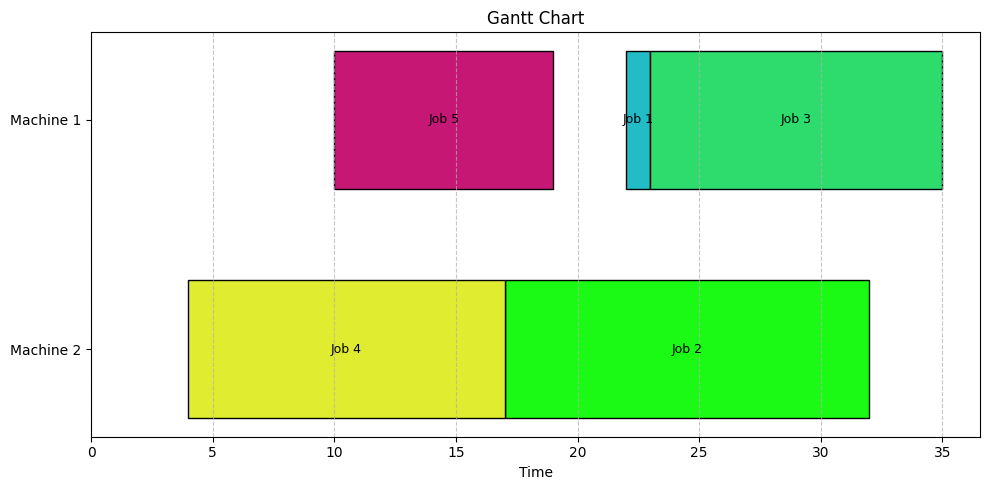

In [21]:
Gantt_Chart.M1_cvxpy_gantt(x, p, J, m)